## Lecture Notes: Basic Image Processing
Before jumping to build powerful and intelligent models for visual recognition it is always important to look at some pixels. Looking at images and pixels and transforming them in various ways gives us often valuable intuitions on how to find things about images, and how to build the algorithms behind intelligent visual recognition systems. 


### 1. Reading Images into Tensors.

In the image processing primer introductory notebook we learned to manipulate ND-arrays using numpy. Here we will be using pytorch's Tensors to manipulate images as tensors. Pytorch is a tensor manipulation library that tries to preserve as much functionality as numpy but it will have other useful tools that we will leverage later in the class. In this section we will just read an RGB image (color image) and show it on Jupyter, then we will show each color channel independently.

Image size:  torch.Size([3, 600, 600])


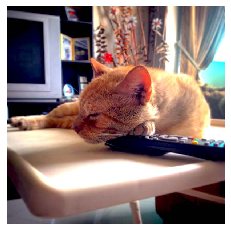

In [29]:
import torch, matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap = 'gray')
import io, requests
from torchvision.transforms import functional as F
from PIL import Image

# Try maybe downloading the image in case the CS webserver goes down.
img_url = 'http://vicenteordonez.com/deeplearning/cat-home.jpg'
response = requests.get(img_url)
img = Image.open(io.BytesIO(response.content))

# Transform into a floating point pytorch tensor.
img = F.to_tensor(img)

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img, figsize = (4.0,4.0)):
  # We need to put channels at the end of the tensor to show
  # a pytorch tensor as an image in matplotlib.
  if img.dim() == 3: img = img.permute(1, 2, 0) 
  plt.figure(figsize = figsize); plt.imshow(img)
  plt.grid(False);  plt.axis('off'); plt.show()
  
display_image(img)

The img variable contains a torch.tensor of size [channels x height x width] corresponding to the dimensions of the image. Since this is a color image it contains Red, Green and Blue channels (RGB). Each entry is a floating-point number between 0 and 1. The code below slices each channel from the image and shows the separately (concatenated using torch.cat along the width dimension --- dimension 1).

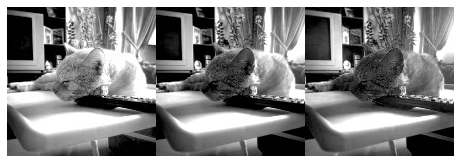

In [4]:
r_image = img[0, :, :]
g_image = img[1, :, :]
b_image = img[2, :, :]

display_image(torch.cat((r_image, g_image, b_image), 1), figsize = (8.0, 4.0))
# Also, please review what torch.cat does (nothing to do with felines).

### 2. Computing Image Statistics: Histograms

Histograms are useful because images can be of different sizes, but histograms can be computed to be of the same size regardless of image dimensions. Additionally we can normalize histograms so they sum to 1, or their  $\ell_2$ norm is 1 (euclidean norm, Frobenius norm in matrices).

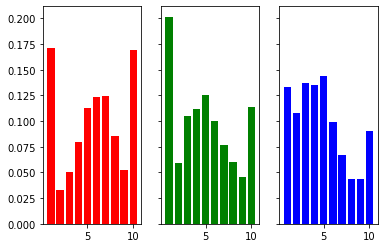

In [5]:
r_image = img[0, :, :]
g_image = img[1, :, :]
b_image = img[2, :, :]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True);
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color = 'r');
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color = 'g');
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color = 'b');

### 3. Manipulating Images Pixel by Pixel

In this section, we will apply pixel-wise operations on the image. A pixel is just the tuple of (red, green, blue) values for a corresponding location (row, column) in the image tensor. A simple operation is making the image brighter by scaling each pixel value in every location by a constant, since each pixel represents color intensity at each location

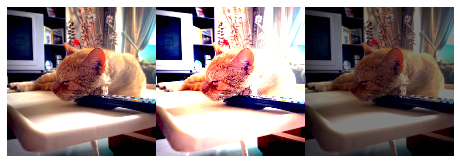

In [6]:
brighter_image = (2.1 * img).clamp_(0, 1)
darker_image = (0.5 * img)

display_image(torch.cat((img, brighter_image, darker_image), 2), figsize = (8.0, 4.0))

There are a couple of things you have to pay attention here: (1) we are using pytorch scalar-tensor operations, the multiplication of the scalar 2.1 affects every entry in the tensor img, and (2) we are using clamp_ which is an in-place operator (all operators with an underscore are in-place in pytorch), which is used to avoid overflowing the pixel values, or making the go beyond the valid range of values which is between 0 and 1. You should learn to peruse pytorch's vast documentation in order to learn all the operations you might need to perform on tensors: https://pytorch.org/docs/stable/tensors.html

### 4. Manipulating Images with Convolutions: Image Filtering



Let's assume a grayscale image (single channel). A convolution is a function that takes an input 2D image $I(x,y)$ and outputs a filtered imaged $I'(x,y)$ such that $I'(x, y) = f(\text{neighborhood of } I(x, y))$. This means that in order to compute the value of the output pixel $I'(x, y)$ we will need not only the input pixel value $I(x, y)$ (as we did for brightness) but also its neighboring pixel values. This is not a strict definition but this is the basic idea.

Most convolution operations we will be using during the course will use an $n\text{x}n$ number of neighboring pixels, and will be of the form:

$$I'(u,v) = \sum_{i=0}^{n-1}\sum_{j=0}^{n-1}{w_{i,j}I(u - \lfloor n / 2 \rfloor + i, v-\lfloor n / 2 \rfloor + j)} + b$$

For the purpose of this lab tutorial $b$ will be zero, so the only parameters of our convolution operations will be the size of our neighborhood region $n$ and the weights $w_{i,j}$. Moreover, for the first few examples here the neighborhod size will be $3\text{x}3$, thus we will be dealing with the following operation to compute the output pixels $I'(u, v)$.

\begin{equation}
\begin{split}
I'(u,v) =\quad  &w_{0,0}I(u - 1, v - 1)\quad  &+\quad &w_{0,1}I(u - 1, v)\quad &+\quad &w_{0,2}I(u - 1, v + 1) \quad+ \\
          &w_{1,0}I(u, v - 1)\quad  &+\quad &w_{1,1}I(u, v)\quad &+\quad &w_{1,2}I(u, v + 1) \quad+ \\
          &w_{2,0}I(u + 1, v - 1)\quad  &+\quad &w_{2,1}I(u + 1, v)\quad &+\quad &w_{2,2}I(u + 1, v + 1) \quad+
\end{split}
\end{equation}

We are effectively computing a sliding window as illustrated here:

<img width="560" src="http://www.cs.virginia.edu/~vicente/recognition/notebooks/animation.gif" />

In practice, there are various ways of making the convolution operations faster by realizing that some computations are shared by consecutive windows, or by sacrificing memory and expressing the convolution as a single matrix multiplication, GPU acceleration is also possible and fortunately all of these are already implemented in pytorch. Convolutions are essential to obtain information from images as well as to apply many common effects to images like blurring, sharpening, etc. In pytorch we can use the F.conv2d function to an input image. Here we will run a convolution on a grayscale version of the image using a kernel of size 3x3 where all the entries are 1/9.

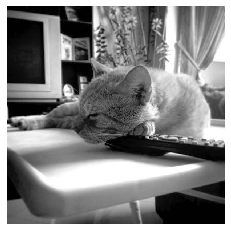

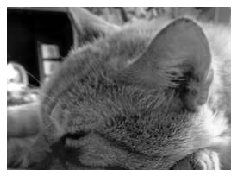

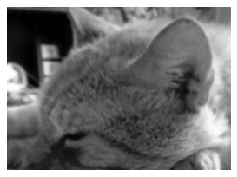

In [30]:
# The input is just a section of the red channel.
# We will take the pixels between rows 150:340 and columns 160:420.
gray_img = (img[0, :, :] + img[1, :, :] + img[2, :, :]) / 3.0
display_image(gray_img, figsize = (8.0, 4.0))

input_image = gray_img[150:340, 160:420]

# The kernel is a 3x3 matrix that computes the average around the pixel.
kv = 1.0 / 9.0
blur_weights = torch.Tensor([[kv, kv, kv],
                             [kv, kv, kv],
                             [kv, kv, kv]])

# Do not worry about the details of this implementation. 
# The reason for unsqueezes is because the F.conv2d function is very general, 
# and works for multiple images at a time, and multiple channels at a time, 
# and for multiple kernels at a time. See pytorch's doc for torch.unsqueeze()
def SingleChannelConvolution(input_image, kernel):
    import torch.nn.functional as F
    kernel = kernel.contiguous()
    output = F.conv2d(input_image.unsqueeze(0).unsqueeze(0), 
                      kernel.unsqueeze(0).unsqueeze(0))
    return output.squeeze()
    
# Execute the convolution operation
output_image = SingleChannelConvolution(input_image, blur_weights)

display_image(input_image, figsize = (4.0, 4.0))
display_image(output_image, figsize = (4.0, 4.0))

The above results show the original image and the image after the convolution operator. It clearly shows that the image hs been blurred. One could blur the image using a larger kernel size than 3x3 or using different weights kv.

Now here are other filters that highlight vertical and horizontal edges in the input. These are also sometimes referred to as Sobel operators, and there are also finite differences that approximate the gradients of the image (This is the equivalent to taking a derivative of a function, except that here we have 2D functions in the discrete domain). We compute the sobel operator in the x-dimension and y-dimension. Each will highlight either vertical or horizontal edges, and the magnitude of these two gradients highlights all the edges.

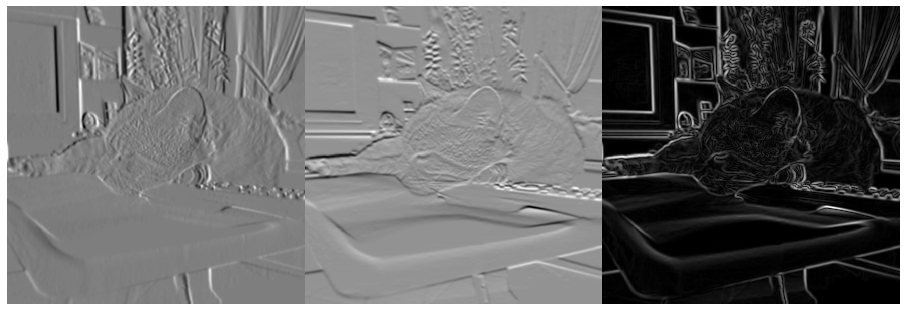

In [8]:
# The input is the grayscale channel image after a few rounds of blurring.
input_image = SingleChannelConvolution(gray_img, blur_weights)
input_image = SingleChannelConvolution(input_image, blur_weights.clone())
input_image = SingleChannelConvolution(input_image, blur_weights.clone())

# The kernel is a 3x3 matrix that computes the Sobel operator.
# See https://en.wikipedia.org/wiki/Sobel_operator
weights = torch.tensor([[1.0, 0.0, -1.0],
                        [2.0, 0.0, -2.0],
                        [1.0, 0.0, -1.0]])

# Execute the convolution operation for the weights and transposed weights.
gradx = SingleChannelConvolution(input_image, weights)
grady = SingleChannelConvolution(input_image, weights.t())

# Gradient magnitude  = sqrt(gradx.^2 + grady.^2)
magnitude = torch.sqrt(gradx * gradx + grady * grady)

# Make sure the images are still between 0 and 1.
gradx = (gradx - gradx.min()).div(gradx.max() - gradx.min())
grady = (grady - grady.min()).div(grady.max() - grady.min())
magnitude = magnitude / magnitude.max()

# Display the output.
display_image(torch.cat((gradx, grady, magnitude), 1), figsize=(16,8));


We could also apply convolutions channel by channel and reconstruct the original image by merging the outputs for each convolution. We could also apply a different kernel to each channel. In fact the kernel matrix could also be an image itself. We will illustrate this below.

torch.Size([3, 10, 10])
output torch.Size([3, 591, 591])
rgb_image torch.Size([3, 600, 600])


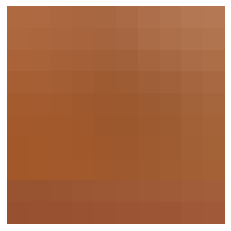

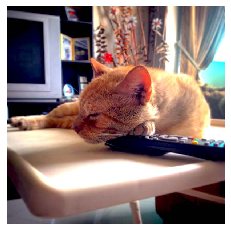

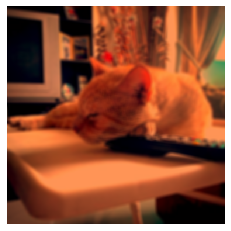

In [9]:
# Crop a patch from the image itself to use as convolutional filter.
rgb_image = img.clone()
kernel_patch = img[:, 280:290, 160:170]
print(kernel_patch.shape)

output1 = SingleChannelConvolution(rgb_image[0, :, :], kernel_patch[0, :, :])
output2 = SingleChannelConvolution(rgb_image[1, :, :], kernel_patch[1, :, :])
output3 = SingleChannelConvolution(rgb_image[2, :, :], kernel_patch[2, :, :])

# Add a dummy channel dimension to each output and concat across this dimension.
output_image = torch.cat((output1[np.newaxis, :, :], 
                          output2[np.newaxis, :, :],
                          output3[np.newaxis, :, :]), 0)

output_image = (output_image - output_image.min()) / \
               (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

display_image(kernel_patch)
display_image(rgb_image)
display_image(output_image)

Here is another example where we sample a different patch from the image to use as filter. As you can see, there is relationship between the apperance of the filter and the output image.

torch.Size([3, 10, 10])
output torch.Size([3, 591, 591])
rgb_image torch.Size([3, 600, 600])


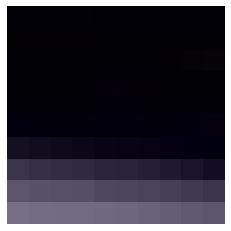

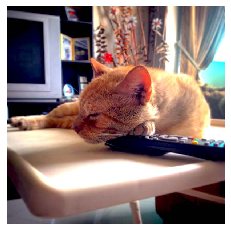

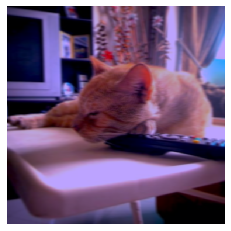

In [10]:
# Crop a patch from the image itself to use as convolutional filters.
rgb_image = img.clone()
kernel_patch = img[:, 15:25, 100:110]
print(kernel_patch.shape)

output1 = SingleChannelConvolution(rgb_image[0, :, :], kernel_patch[0, :, :])
output2 = SingleChannelConvolution(rgb_image[1, :, :], kernel_patch[1, :, :])
output3 = SingleChannelConvolution(rgb_image[2, :, :], kernel_patch[2, :, :])

# Add a dummy channel dimension to each output and concat across this dimension.
output_image = torch.cat((output1[np.newaxis, :, :], 
                          output2[np.newaxis, :, :],
                          output3[np.newaxis, :, :]), 0)

output_image = (output_image - output_image.min()) / \
               (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

display_image(kernel_patch)
display_image(rgb_image)
display_image(output_image)

torch.Size([3, 9, 59])
output torch.Size([3, 591, 541])
rgb_image torch.Size([3, 599, 599])


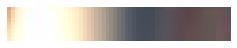

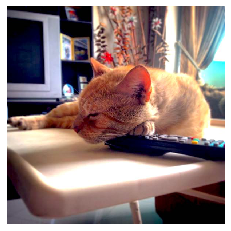

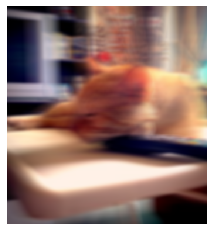

In [35]:
# Crop a patch from the image itself to use as convolutional filters.
rgb_image = img.clone()
#kernel_patch = img[:, 15:25, 440:500]
kernel_patch = img[:, 15:24, 441:500]
rgb_image = img[:, 1:, 1:]

print(kernel_patch.shape)


output1 = SingleChannelConvolution(rgb_image[0, :, :], kernel_patch[0, :, :])
output2 = SingleChannelConvolution(rgb_image[1, :, :], kernel_patch[1, :, :])
output3 = SingleChannelConvolution(rgb_image[2, :, :], kernel_patch[2, :, :])

# Add a dummy channel dimension to each output and concat across this dimension.
output_image = torch.cat((output1[np.newaxis, :, :], 
                          output2[np.newaxis, :, :],
                          output3[np.newaxis, :, :]), 0)

output_image = (output_image - output_image.min()) / \
               (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

display_image(kernel_patch)
display_image(rgb_image)
display_image(output_image)

## Assignment (100pts)

The purpose of this assignment is to make sure you have the pytorch environment installed and running, or that you get started using Google Colaboratory, and familiarize yourself with some basic image processing routines. In addition to completing the above tutorial, here are the items you have to submit for grading. **Important:** Make sure to include the output of your code below (TAs will generally not run your code, your assignments will be graded based on the quality of your output). 


### 1. Up-Down Vertical Faded Glow (40pts)



Generate the output below using what you know about tensors and tensor operations. The idea is that pixels in the bottom row and top row are fully white and this glow fades out as the pixels are closer to the row in the center of the image. Use the provided output as your guide to implement your function. Your output doesn't have to match exactly but must be of similar quality. Also don't worry about efficiency, feel free to use for loops if needed for this exercise.

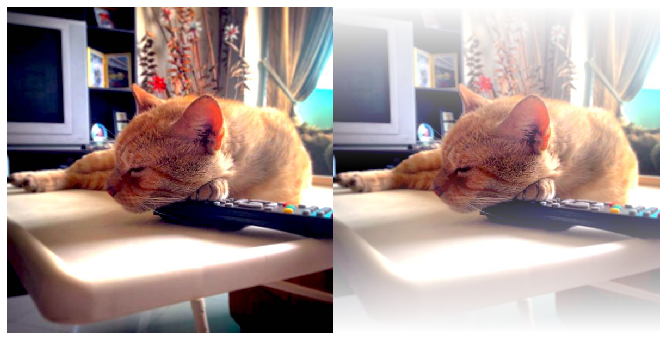

In [12]:
import torch, matplotlib, math
import numpy as np
import matplotlib.pyplot as plt
import io, requests
from torchvision.transforms import functional as F
from PIL import Image

# Try maybe downloading the image in case the CS webserver goes down.
img_url = 'http://vicenteordonez.com/deeplearning/cat-home.jpg'
response = requests.get(img_url)
img = Image.open(io.BytesIO(response.content))

# Transform into a floating point pytorch tensor.
img = F.to_tensor(img)
outimg = img.clone()

# Your code goes here.
# Note: we do not need convolution for this. Fading is just the convex
# combination of the existing pixels and a new pixel

for i in range(int(img.shape[1]/2)):
  alpha = i/(img.shape[1]/2 - 1) # Weight of existing pixels
  beta = 1 - alpha

  row = torch.from_numpy(np.zeros(600) + beta).clamp_(0, 1)
  outimg[0, i, :] = outimg[0, i, :] * (alpha) + row
  outimg[1, i, :] = outimg[1, i, :] * (alpha) + row
  outimg[2, i, :] = outimg[2, i, :] * (alpha) + row

  outimg[0, img.shape[1] - 1 - i, :] = outimg[0, img.shape[1] - 1 - i, :] * (alpha) + row
  outimg[1, img.shape[1] - 1 - i, :] = outimg[1, img.shape[1] - 1 - i, :] * (alpha) + row
  outimg[2, img.shape[1] - 1 - i, :] = outimg[2, img.shape[1] - 1 - i, :] * (alpha) + row

# Plot the image.
def display_image(img, figsize = (4.0,4.0)):
  plt.figure(figsize = figsize);
  plt.imshow(img.permute(1, 2, 0))
  plt.grid(False);  plt.axis('off'); plt.show()
  
display_image(torch.cat((img, outimg), 2), figsize=(12,6))

### 2. Radial Tilt Shift (50pts)


If you go to Instagram -> Edit -> Tilt Shift -> Radial you will find this effect. Please create a function that creates this effect where the center of the image is in focus and then things get blurry as pixels get far away from the center of the image. The idea will be to blur the whole image, and then interpolate this blurred image with the original image to obtain the pixels in the final image. For instance, copy pixels from the blurred image for the borders, and copy pixels from the unblurred image for the center, and for other pixels use interpolation based on distance from the center of the image. I recommend using a blurring filter of size at least 15x15 for the first step. HINT: Use padding = 7 for the conv2d function so the blurred image and input image are of the same size. (In instagram you can also pick a point different than the center of the image, you're not required to support that). The center of your image has to be noticeably sharp and the boundaries of your image have to be noticeably blurry for your answer to be awarded full points.

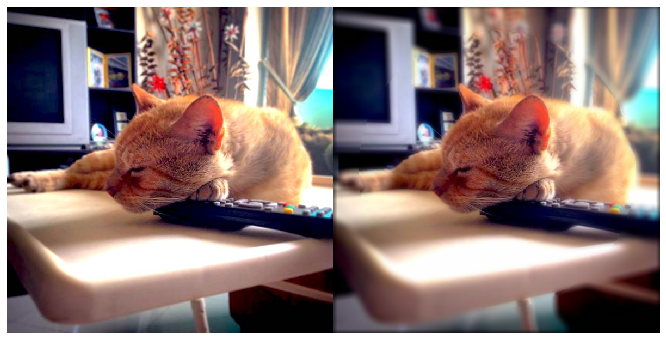

In [24]:
import torch, matplotlib, math
import numpy as np
import matplotlib.pyplot as plt
import io, requests
from torchvision.transforms import functional as F
from PIL import Image

# Try maybe downloading the image in case the CS webserver goes down.
img_url = 'http://vicenteordonez.com/deeplearning/cat-home.jpg'
response = requests.get(img_url)
img = Image.open(io.BytesIO(response.content))

# Transform into a floating point pytorch tensor.
img = F.to_tensor(img)

def SingleChannelConvolution(input_image, kernel):
    import torch.nn.functional as F
    kernel = kernel.contiguous()
    output = F.conv2d(input_image.unsqueeze(0).unsqueeze(0), 
                      kernel.unsqueeze(0).unsqueeze(0), padding = 7)
    return output.squeeze()


def focus_image(img, center = None, radius = None):
  # The kernel is a 15x15 matrix that computes the average around the pixel.
  kv = 1.0 / (15 * 15)
  blur_weights = torch.ones(15, 15) * kv

  if(center == None):
    center = (img.shape[1]/2, img.shape[2]/2)

  if(radius == None):
    radius = img.shape[2]/10 # Default 1/10 of the width 

  outimg = img.clone()
  a = math.sqrt((center[0] - 0) ** 2 + (0 - center[1]) ** 2)
  b = math.sqrt((center[0] - 0) ** 2 + (img.shape[2] - center[1]) ** 2)
  c = math.sqrt((center[0] - img.shape[1]) ** 2 + (0 - center[1]) ** 2)
  d = math.sqrt((center[0] - img.shape[1]) ** 2 + (img.shape[2] - center[1]) ** 2)

  farthest_point = max(a, b, c, d)

  # Execute the convolution operation channel by channel.

  output1 = SingleChannelConvolution(img[0, :, :], blur_weights[:, :])
  output2 = SingleChannelConvolution(img[1, :, :], blur_weights[:, :])
  output3 = SingleChannelConvolution(img[2, :, :], blur_weights[:, :])

  # Add a dummy channel dimension to each output and concat across this dimension.
  blurred_image = torch.cat((output1[np.newaxis, :, :], 
                            output2[np.newaxis, :, :],
                            output3[np.newaxis, :, :]), 0)

  # Traversing a matrix! So slow! Not concerened with efficiency at the moment.
  alpha_matrix = []
  for i in range(0, img.shape[1]):
    alpha_vector = []
    for j in range(0, img.shape[2]):

      distance_from_center = math.sqrt((center[0] - i) ** 2 + (j - center[1]) ** 2)
      #print(distance_from_center)

      alpha = 0 # weight of blurry image
      if(distance_from_center < radius):
        alpha = 0
      elif(distance_from_center >= radius):
          if(distance_from_center < farthest_point * .60):
            alpha = distance_from_center/farthest_point
          # print(alpha)
          else:
            alpha = 1

      #print(alpha)
      alpha_vector.append(alpha)

      outimg[0, i, j] = (blurred_image[0, i, j] * alpha) + (img[0, i, j] * (1 - alpha))
      outimg[1, i, j] = (blurred_image[1, i, j] * alpha) + (img[1, i, j] * (1 - alpha))
      outimg[2, i, j] = (blurred_image[2, i, j] * alpha) + (img[2, i, j] * (1 - alpha))

    alpha_matrix.append(alpha_vector)

  return outimg

outimg = focus_image(img, (300, 300), 20)

# Plot the image.
def display_image(img, figsize = (4.0,4.0)):
  plt.figure(figsize = figsize); plt.imshow(img.permute(1, 2, 0))
  plt.grid(False);  plt.axis('off'); plt.show()

display_image(torch.cat((img, outimg), 2), figsize=(30,6))  


We can more easily show that focusing functionality by working with the image of white noise.

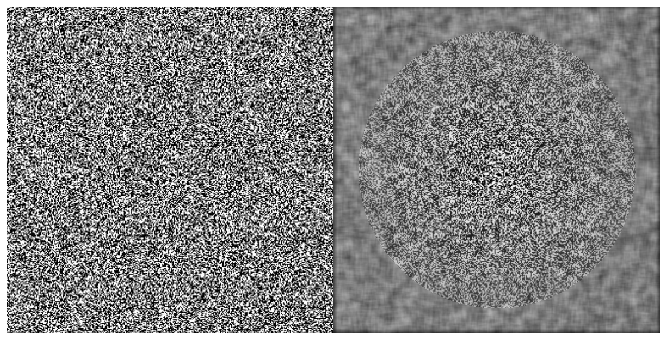

Plotting the difference:


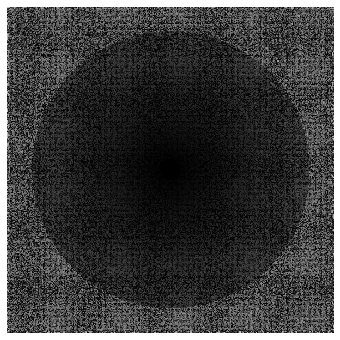

In [26]:
fp = open("white-noise.jpg","rb")
img = Image.open(fp)

# Transform into a floating point pytorch tensor.
img = F.to_tensor(img)

outimg = focus_image(img, radius = 2)

outimg = focus_image(img, (300, 300), 20)
display_image(torch.cat((img, outimg), 2), figsize=(30,6))
print("Plotting the difference:")
display_image(abs(img - outimg), figsize=(30,6))  


### 3. Convolution Input/Output Shapes (10pts)




 In the last example of this tutorial, when we convolved the image with a patch. Why did the output_image (3 x 591 x 541) and the input rgb_image (3 x 600 x 600) have different width and height? Explain what is the precise relationship between the height of the input and output, and the width of the input and output.

In [0]:
# Explain your reasoning and provide here the formula. Feel free to add a Text Cell instead of this code cell.

The size out the ouput is determined by the shape of the kernel patch. The kernel patch shape is (3 x 10 x 60). Convolution is performed by striding across the image for each channel. However, we cannot fit the entire filter over regions near the corners, as it would need to go beyond the edges of the image. The kernel is not square, which means the width and height will be different. The dimensions can be calculated as follows:


**out_image_height = rgb_image.shape[1] - kernel_patch.shape[1] + 1**

**out_image_width = rgb_image.shape[2] - kernel_patch.shape[2] + 1**

Padding needs be added to the input image to make the inputs have the same dimnensions.